# Simulations for supplemental material.
Original version: 06/28/2018. This version: 07/29/2019 (pyGSTi compatability updates).

This notebook contains code to:
1. Generate the data used for the simulations presented in the Supplemental Material text (which is appended to the main text in the arXiv version).
2. The data analysis we used.
To use this notebook it is necessary to install the python package `pyGSTi` http://www.pygsti.info. This notebook should be used with `pygSTi` version 0.9.8, the latest version as of this writing.

This notebook uses various features of `pyGSTi` without detailed explanations. For further information on using `pyGSTi` for DRB see: 
- The experiment data analysis notebook, in this supplemental material.
- The RB tutorial notebooks contained within `pyGSTi`.
- The `pyGSTi` docstrings.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports for python2 compatability.
from __future__ import division, print_function, absolute_import, unicode_literals

# pyGSTi imports. This code requires pyGSTi version 0.9.5
import pygsti
from pygsti.extras import rb
from pygsti.baseobjs import Label

The number of qubits

In [2]:
n = 5

The parameters of the error model (see the Supplemental Material text for further information).

In [3]:
# Error rate of the central qubit when controlling a CNOT
central_to_outer_controlerror = 0.04
# Error rate of outer qubit when a target of a CNOT from the central qubit
central_to_outer_targeterror = 1-((1-0.08)/(1-0.04))**(1/4)
# Error rate of outer qubit when spectating a CNOT from the central qubit
central_to_outer_othertargetserror = central_to_outer_targeterror

# Error rate of an outer qubit when controlling a CNOT
outer_to_outer_controlerror = 1-(1-0.04)**(1/2)
# Error rate of an outer qubit when the target of a CNOT on the ring
outer_to_outer_targeterror = 1-(1-0.04)**(1/2)

# 1-qubit gate error rate (not including idles)
oneqprob = 0.001
# idle error rate
idleprob = 0.001
# Measurement error probability
spam_error = 0.02

## Generating data

The specification of the device (see the `pyGSTi` docstrings for more information)

In [4]:
cnotedges = [(0,1),(1,2),(2,3),(3,0),(4,0),(4,1),(4,2),(4,3)]                   
gllist = ['Gi','Gh','Gp','Gcnot']   
availability = {'Gcnot': cnotedges} 
pspec = pygsti.obj.ProcessorSpec(n, gllist, availability=availability, verbosity=0)  

/Users/tjproct/files/programs/pyGSTi/packages/pygsti/objects/processorspec.py:481: UserWarning:

The identity should often *not* be included in the root gate names of a ProcessorSpec.



Encodes the error model in the format required for the `pyGSTi` Pauli-errors RB simulator 

In [5]:
errormodel = {}

gatelabels = []
gatenames = pspec.root_gate_names
for gn in gatenames:
    for qubits in pspec.availability[gn]:
        gatelabels.append(pygsti.baseobjs.Label(gn,qubits))

for gate in gatelabels:
    errormodel[gate] = np.zeros((n,4),float)
    errormodel[gate][:,0] = np.ones(n,float)
    
    # If not a CNOT, it is a 1-qubit gate / idle.
    if gate.name != 'Gcnot':
        # If the idle gate, use the idle error rate
        if gate.name == 'Gi':
            for q in gate.qubits:
                errormodel[gate][q,:] = np.array([1-idleprob,idleprob/3,idleprob/3,idleprob/3])
        # Otherwise, use the 1-qubit gate error rate
        else:
            for q in gate.qubits:
                errormodel[gate][q,:] = np.array([1-oneqprob,oneqprob/3,oneqprob/3,oneqprob/3])

    if gate.name == 'Gcnot':
        qc = gate.qubits[0]
        qt = gate.qubits[1]
            
        # Different error rates when the control is qubit 4 and when it is not
        if qc != 4:
            eprobc = outer_to_outer_controlerror
            eprobt = outer_to_outer_targeterror  
        else:
            eprobc = central_to_outer_controlerror
            eprobt = central_to_outer_targeterror  
            
        errormodel[gate][qc,:] =  np.array([1-eprobc,eprobc/3,eprobc/3,eprobc/3])
        errormodel[gate][qt,:] =  np.array([1-eprobt,eprobt/3,eprobt/3,eprobt/3])
            
        # If the control is qubit 4, the gate also induces errors on spectator qubits
        if qc == 4:
            for q in range(n):
                if q != qc and q != qt:
                    eprob = central_to_outer_othertargetserror
                    errormodel[gate][q,:] = np.array([1-eprob,eprob/3,eprob/3,eprob/3])

errormodel['measure'] = [spam_error for q in range(n)]

In [6]:
# Labels for the different RB sims (DRB is implemented with 3 different samplers)
rb_names = ['CRB','DRB1','DRB2','DRB3']

# The vectors associated with the three different samplers (see main text).
sampler_vec = {}
sampler_vec['DRB1'] = [1,2,1]
sampler_vec['DRB2'] = [1,1,2]
sampler_vec['DRB3'] = [18,1,1]

sampler = 'co2Qgates'

# This list defines the "sectors" sampling used (see pyGSTi docstrings).
co2Qgates = []

# The local-gates only option. Must be a list 
co2Qgates.append([])

# The 4 CNOTs on the ring are put into a list of lists
subco2Qgates = [[Label('Gcnot',(0,1)),],[Label('Gcnot',(1,2)),],[Label('Gcnot',(2,3)),],[Label('Gcnot',(3,0))]]
co2Qgates.append(subco2Qgates)

# The 4 CNOTs from the central qubit
subco2Qgates = [[Label('Gcnot',(4,0)),],[Label('Gcnot',(4,1)),],[Label('Gcnot',(4,2)),],[Label('Gcnot',(4,3)),]]
co2Qgates.append(subco2Qgates)

# The distribution over these co2Qgates varies with the sampler
sdist = {}
sdist['DRB1'] = sampler_vec['DRB1']
sdist['DRB2'] = sampler_vec['DRB2']
sdist['DRB3'] = sampler_vec['DRB3']

samplerargs = {}
# The arguments handed to the sample by sectors function -- along with `sampler`, defines the DRB sampling.
samplerargs['DRB1'] = [co2Qgates,sdist['DRB1']]
samplerargs['DRB2'] = [co2Qgates,sdist['DRB2']]
samplerargs['DRB3'] = [co2Qgates,sdist['DRB3']]

addlocal = False
lsargs = []

randomizeout = False

drb_citerations = 100
crb_citerations = 25

# Optimze the stabilizer compiler for the connectivity.
eliminateorder = [0,1,4,2,3]
drb_compilerargs = [False, 'OCAGE', [eliminateorder,]]
# The default Clifford compiler is our best option here.
crb_compilerargs = []

rbspec = {}
rbspec['DRB1'] = [sampler, samplerargs['DRB1'], addlocal, lsargs, randomizeout, True, True, 
                 drb_citerations, drb_compilerargs]
rbspec['DRB2'] = [sampler, samplerargs['DRB2'], addlocal, lsargs, randomizeout, True, True, 
                 drb_citerations, drb_compilerargs]
rbspec['DRB3'] = [sampler, samplerargs['DRB3'], addlocal, lsargs, randomizeout, True, True, 
                 drb_citerations, drb_compilerargs]
rbspec['CRB'] = [randomizeout, crb_citerations, crb_compilerargs]

# circuits per length
k = 50
# counts per circuit
N = 100
# lengths for the DRB sims
lengths = {}
lengths['DRB'] = [0,          10,20,30,40,50,60,80,100,140,180,220]
# lengths for the CRB sims
lengths['CRB'] = [0,1,2,3,4,5,10,20,30,40,50,60,80,100,140,180,220]

The simulations

In [7]:
dosims = False

In [8]:
if dosims:
    base_filename = "supplemental_simulation_newdata"
    for rbn in rb_names:
        print("\n ----- simulations for {} -----".format(rbn),end='\n\n')
        filename = base_filename + '_{}.txt'.format(rbn)
        rb.simulate.rb_with_pauli_errors(pspec, errormodel, lengths[rbn[:3]], k, N, subsetQs=None, 
                                         idle1Q_placeholder='Gi', filename=filename, rbtype=rbn[:3], 
                                         rbspec=rbspec[rbn], verbosity=1)        

## Data analysis

We now import and analyze the previously generated data, that we presented in the Supplemental Material text.

In [9]:
label_to_filename = {}
label_to_filename['CRB'] = 'supplemental_simulation_data_CRB.txt'
label_to_filename['DRB1'] = 'supplemental_simulation_data_DRB1-1-2-1-sampling.txt'
label_to_filename['DRB2'] = 'supplemental_simulation_data_DRB2-1-1-2-sampling.txt'
label_to_filename['DRB3'] = 'supplemental_simulation_data_DRB3-18-1-1-sampling.txt'

In [10]:
data = {}
for rbn in rb_names:
    fn = label_to_filename[rbn]
    data[rbn] = rb.io.import_rb_summary_data(fn)

Importing supplemental_simulation_data_CRB.txt...Complete.
Importing supplemental_simulation_data_DRB1-1-2-1-sampling.txt...Complete.
Importing supplemental_simulation_data_DRB2-1-1-2-sampling.txt...Complete.
Importing supplemental_simulation_data_DRB3-18-1-1-sampling.txt...Complete.


In [11]:
# Generates bootstrapped datasets.
bootstraps = 2000
for rbn in rb_names:
    print("Generating bootstraps for {} data... ".format(rbn),end='')
    data[rbn].add_bootstrapped_datasets(bootstraps)
    print("complete.")

Generating bootstraps for CRB data... complete.
Generating bootstraps for DRB1 data... complete.
Generating bootstraps for DRB2 data... complete.
Generating bootstraps for DRB3 data... complete.


In [12]:
# Seeds for B and p in A + Bp^m
seed = {}
seed['CRB'] = [0.05,0.1]
seed['DRB1'] = [0.4,0.95]
seed['DRB2'] = [0.4,0.9]
seed['DRB3'] = [0.4,0.9]

# Dicts for storing information about the fit
estimates = {}
bootstrapped_r = {}
fitfailcount = {}
r = {}
r_std = {}
for rbn in rb_names:
    print("Implementing fits for {}... ".format(rbn),end='')
    lengths = data[rbn].lengths
    ASPs = data[rbn].ASPs
    fit = rb.analysis.std_least_squares_data_fitting(lengths, ASPs, n, seed=seed[rbn],
                                                     asymptote=1/2**n, ftype='FA')
    if not fit['success']:
        print("Fit failed!")
    estimates[rbn] = fit['estimates']
        
    # Repeat the analysis on the boostrapped data
    bootstrapped_r[rbn] = []
    fitfailcount[rbn] = 0
    for i in range(bootstraps):            
        ASPs = data[rbn].bootstraps[i].ASPs
        bsfit = rb.analysis.std_least_squares_data_fitting(lengths, ASPs, n, seed=seed[rbn], 
                                                                   asymptote=1/2**n, ftype='FA')            
        if bsfit['success']:
            bootstrapped_r[rbn].append(bsfit['estimates']['r'])
        else:
            fitfailcount[rbn] += 1
        r[rbn] = estimates[rbn]['r']
        r_std[rbn] = np.std(np.array(bootstrapped_r[rbn]))
    print('complete (failcount = {}).'.format(fitfailcount[rbn]))

Implementing fits for CRB... complete (failcount = 0).
Implementing fits for DRB1... complete (failcount = 0).
Implementing fits for DRB2... complete (failcount = 0).
Implementing fits for DRB3... complete (failcount = 0).


In [13]:
# Prints the results
for rbn in rb_names:    
    print("{} has r = {:0.3} +/-  {:0.2}".format(rbn,r[rbn],r_std[rbn]))

CRB has r = 0.827 +/-  0.08
DRB1 has r = 0.0419 +/-  0.0019
DRB2 has r = 0.0518 +/-  0.0028
DRB3 has r = 0.0107 +/-  0.00059


In [14]:
# Data plotting function
def plot_data(data, estimates=None, size=(6,2), ylim=None):
    
    plt.figure(figsize=size)
    plt.plot(data.lengths,data.ASPs,'o')
    lengths = np.linspace(0,max(data.lengths),200)
    
    if estimates is not None:
        A = estimates['A']
        B = estimates['B']
        p = estimates['p']
        plt.plot(lengths,A+B*p**lengths)
    plt.violinplot(list(data.success_probabilities),data.lengths,points=10, widths=1., showmeans=True, 
                   showextrema=False, showmedians=False)
    
    plt.ylabel("Success probability")
    plt.xlabel("Seqence length")
    plt.ylim(ylim)
    
    plt.show()

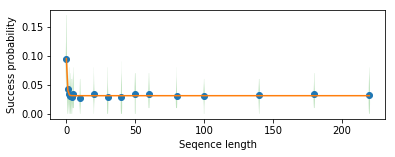

In [15]:
rbn = 'CRB'
plot_data(data[rbn], estimates[rbn], size=(6,2))

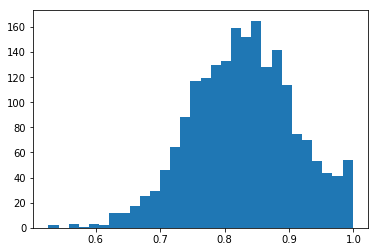

In [16]:
plt.hist(bootstrapped_r[rbn],bins=30)
plt.show()

We now compare the results to the true error probability per random native gate sampled accord to the DRB sampling distribution.

In [17]:
# Error probability of 5Q gate containing only local gates
E1 = 1 - (1-oneqprob)**5

# Error probability of 5Q gate containing outer CNOT + local gate
ring_CNOT_error_rate = 0.04
E2 = 1 - (1-oneqprob)**3 * (1-ring_CNOT_error_rate)

SP_inner_qubit = (1-0.04) 
SP_outer_target_qubit = (1-central_to_outer_targeterror)
SP_outer_other_qubit = (1-oneqprob)*(1-central_to_outer_othertargetserror) + oneqprob*central_to_outer_othertargetserror/3

# Error probability of 5Q gate containing inner -> outer CNOT + local gate.
E3 = 1 - (SP_inner_qubit)*(SP_outer_target_qubit)*(SP_outer_other_qubit**3)

gate_error_rates = np.array([E1,E2,E3])

predicted_drb_r = {}
for rbn in ['DRB1','DRB2','DRB3']:
    predicted_drb_r[rbn] = np.dot(gate_error_rates,np.array(sampler_vec[rbn]))/np.sum(np.array(sampler_vec[rbn]))   
    
for rbn in ['DRB1','DRB2','DRB3']:    
    print(" {} has observed r = {:0.2} +/-  {:0.1}".format(rbn,r[rbn],r_std[rbn]))
    print("{} has predicted r = {:0.3}".format(rbn,predicted_drb_r[rbn]))

 DRB1 has observed r = 0.042 +/-  0.002
DRB1 has predicted r = 0.0434
 DRB2 has observed r = 0.052 +/-  0.003
DRB2 has predicted r = 0.0533
 DRB3 has observed r = 0.011 +/-  0.0006
DRB3 has predicted r = 0.0108


Next, we estimate the $\epsilon_1$, $\epsilon_2$ and $\epsilon_3$ error rates (defined in the Supplemental Material text), using simple linear algebra.

In [18]:
M = np.array([np.array(sampler_vec[rbn])/np.sum(np.array(sampler_vec[rbn])) for rbn in ['DRB1','DRB2','DRB3']])
Minv = np.linalg.inv(M)
rvec = np.array([r[rbn] for rbn in ['DRB1','DRB2','DRB3']])
evec = np.dot(Minv,rvec)

bs_evec = np.zeros((3,bootstraps))
for i in range(bootstraps):
    bs_rvec = np.array([bootstrapped_r[rbn][i] for rbn in ['DRB1','DRB2','DRB3']])
    bs_evec[:,i] = np.dot(Minv,bs_rvec)
    
evec_std = np.std(bs_evec,axis=1)
for i in range(3):
    print('  Estimate of epsilon{}: {:0.2} +/- {:0.1}'.format(i+1,evec[i],evec_std[i]))
    print('True value of epsilon{}: {:0.2}'.format(i+1,gate_error_rates[i]))
    print('')

  Estimate of epsilon1: 0.0051 +/- 0.0007
True value of epsilon1: 0.005

  Estimate of epsilon2: 0.041 +/- 0.006
True value of epsilon2: 0.043

  Estimate of epsilon3: 0.081 +/- 0.008
True value of epsilon3: 0.083



Then we use these estimates to estimate the error rates of: 1-qubit gates, CNOT gates on the ring, CNOT gates from the center to the ring.

In [19]:
oneQ_estimate = 1 - (1 - evec[0])**(1/5)
CNOTonring_estimate = 1- (1-evec[1])/(1-oneQ_estimate)**3
CNOTtoring_estimate = 1- (1-evec[2])/(1-oneQ_estimate)**3

bs_oneQ_estimate = []
bs_CNOTonring_estimate = []
bs_CNOTtoring_estimate = []
for i in range(bootstraps):
    bs_oneQ_estimate.append(1 - (1 - bs_evec[0,i])**(1/5))
    bs_CNOTonring_estimate.append(1- (1-bs_evec[1,i])/(1-bs_oneQ_estimate[-1])**3)
    bs_CNOTtoring_estimate.append(1- (1-bs_evec[2,i])/(1-bs_oneQ_estimate[-1])**3)    

oneQ_estimate_std = np.std(np.array(bs_oneQ_estimate))
CNOTonring_estimate_std = np.std(np.array(bs_CNOTonring_estimate))
CNOTtoring_estimate_std = np.std(np.array(bs_CNOTtoring_estimate))
print('1Q error rate estimate:')
print('{:0.2} +/- {:0.1}'.format(oneQ_estimate,oneQ_estimate_std))
print('True value:')
print(0.001)
print('CNOT on ring error rate estimate:')
print('{:0.2} +/- {:0.1}'.format(CNOTonring_estimate,CNOTonring_estimate_std))
print('True value:')
print(0.04)
print('CNOT from center to ring error rate estimate:')
print('{:0.2} +/- {:0.1}'.format(CNOTtoring_estimate,CNOTtoring_estimate_std))
print('True value:')
print(0.08)

1Q error rate estimate:
0.001 +/- 0.0001
True value:
0.001
CNOT on ring error rate estimate:
0.038 +/- 0.006
True value:
0.04
CNOT from center to ring error rate estimate:
0.078 +/- 0.008
True value:
0.08
